In [1]:
from nipype.algorithms.metrics import FuzzyOverlap
from nilearn.image import resample_to_img
from scipy.stats import pearsonr
from __future__ import division
import matplotlib.pyplot as plt
from collections import Counter
from nilearn import plotting
import nibabel as nib
import seaborn as sns
import pandas as pd
import numpy as np
import palettable
import sys
import os

sys.path.append(os.path.join(os.environ.get("HOME"),"CNP_analysis"))
from utils import get_config
from utils.prog import log_progress as lp

%matplotlib inline

sns.set_style('white')

cols = palettable.tableau.ColorBlind_10.hex_colors
cols += palettable.tableau.PurpleGray_6.hex_colors
cols += palettable.tableau.Tableau_10.hex_colors

/home/jdurnez/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
pipelines= ['fmriprep-1.0.3','fslfeat_5.0.9']

In [3]:
basedir = os.path.join(os.environ.get("PREPBASEDIR"),"fmriprep_vs_feat")

# Example: 1 (random) group analysis

In [4]:
samplesize = 50
experiment = np.random.choice(range(200,400))
sample = 0
im = 'OLS/stats/tstat1.nii.gz' #eg. contrary to randomise

tstatfile = {}
pstatfile = {}
tstat = {}

for pipeline in pipelines:
    tfile = os.path.join(basedir,pipeline,'task_group/samplesize_%i/experiment_%i/stopsignal'%(samplesize,experiment),
                                         'sample_%i/cope11/%s'%(sample,im))
    tstatfile[pipeline]=tfile
    pfile = os.path.join(basedir,pipeline,'task_group/samplesize_%i/experiment_%i/stopsignal'%(samplesize,experiment),
                                         'sample_%i/cope11/OLS/stats/pstat1.nii.gz'%sample)
    pstatfile[pipeline]=pfile
    tstat[pipeline]=nib.load(tfile).get_data()


### T distributions of example group study

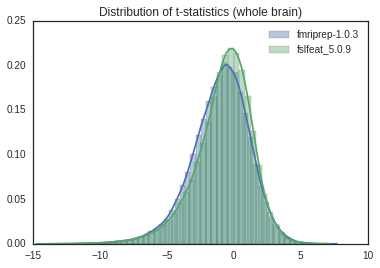

In [5]:
for pipeline in pipelines:
    ts = tstat[pipeline]
    sns.distplot(ts[ts!=0],label=pipeline)

plt.title("Distribution of t-statistics (whole brain)")
plt.legend()

/share/PI/russpold/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


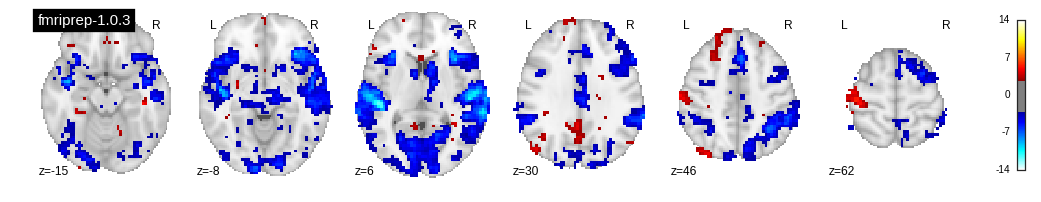

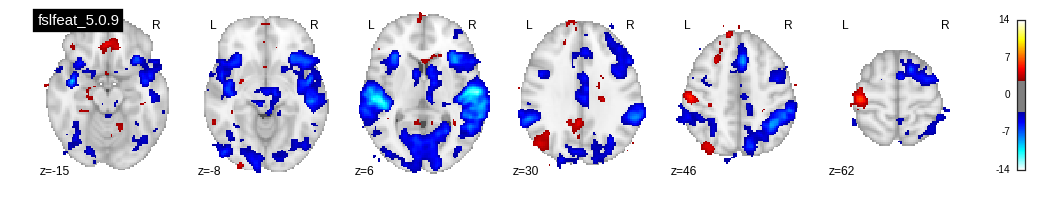

In [6]:
cut_coords = [-15, -8, 6, 30, 46, 62]
for pipeline in pipelines:
    ts = tstatfile[pipeline]
    plotting.plot_stat_map(ts,title=pipeline,threshold=2.98,display_mode='z',cut_coords=cut_coords,vmax=14)
plotting.show()

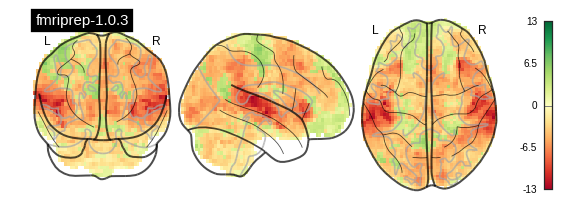

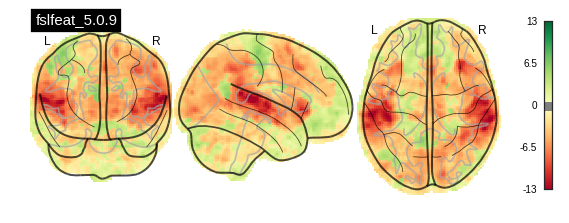

In [7]:
for pipeline in pipelines:
    ts = tstatfile[pipeline]
    plotting.plot_glass_brain(ts,title=pipeline,cmap='RdYlGn',
                              vmax = 13,colorbar=True,symmetric_cbar=True,plot_abs=False)
plotting.show()

# Atlases and effect sizes in regions

In [8]:
# 1: left STN
# 2: right STN
STN_05 = os.path.join(os.environ.get("FSLDIR"),'data/atlases/STN/STN-maxprob-thr0-0.5mm.nii.gz')
# 4: Inferior Frontal Gyrus, pars triangularis
# 25: Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)
# 7: Precentral gyrus (motor)
HO = os.path.join(os.environ.get("FSLDIR"),'data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-1mm.nii.gz')

In [9]:
STN = resample_to_img(STN_05, HO, interpolation='nearest')
STN_dat = STN.get_data()
HO_dat = nib.load(HO).get_data()

In [10]:
newat = np.zeros(STN.shape[:3])
newat[np.where(HO_dat==7)] = 4
newat[np.where(HO_dat==5)] = 3
newat[np.where(HO_dat==26)] = 2
newat[np.where(STN_dat>0)] = 1
atlas = nib.Nifti1Image(newat,affine=STN.affine,header=STN.header)
labels = {
    1:"STN",
    2:"preSMA",
    3:"IFG",
    4:"PCG"
}

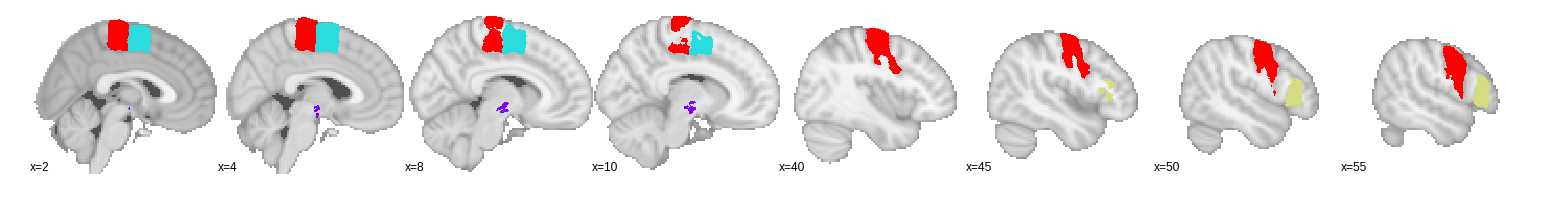

In [11]:
cut_coords = [2,4,8,10,40,45,50,55]
plotting.plot_roi(atlas,display_mode='x',cut_coords=cut_coords,cmap='rainbow',alpha=1)

In [12]:
# make sure there is no overlap
assert(len(np.where(np.logical_and(HO_dat!=0,STN_dat!=0))[0])==0)

In [13]:
ES = {}
for pipeline in pipelines:
    ts = tstatfile[pipeline]
    atlas_resampled = resample_to_img(atlas,ts,interpolation='nearest')
    dat = atlas_resampled.get_data()
    ES[pipeline] = {}
    for k,v in labels.iteritems():
        indxs = np.where(dat==k)
        T = nib.load(tfile).get_data()[indxs]
        CD = np.mean(T)/np.sqrt(samplesize)
        ES[pipeline][v] = CD

In [14]:
pd.DataFrame(ES)

,fmriprep-1.0.3,fslfeat_5.0.9
IFG,-0.065433,-0.154434
PCG,-0.124714,-0.073699
STN,-0.170633,-0.450242
preSMA,-0.078947,-0.194372


# Test-retest replicability for different sample sizes

In [15]:
def fdice(im1,im2):
    overlap = FuzzyOverlap()
    overlap.inputs.in_ref = [im1]
    overlap.inputs.in_tst = [im2]
    overlap.inputs.weighting = 'volume'
    res = overlap.run()
    return res.outputs.dice

In [16]:
def dice(im1,im2):
    binarised = []
    for sample in [im1,im2]:
        thres = nib.load(sample).get_data()
        flt = thres.flatten()
        binarised.append(np.array([1 if x > 0 else 0 for x in flt]))

    sm = binarised[0] + binarised[1]
    dice = np.sum(sm==2)*2/np.sum(sm>0)
    return dice

In [17]:
def cohen(tstat,atlas,labels):
    res = {}
    for k,v in labels.iteritems():
        indxs = np.where(atlas==k)
        T = tstat[indxs]
        CD = np.mean(T)/np.sqrt(samplesize)
        res[v] = CD
    
    return res

In [18]:
def get_file(samplesize,experiment,sample,basedir,analysis='OLS',thres='FWE'):
    out = {}
    
    for pipeline in pipelines:
        
        out[pipeline] = {}
        
        for sample in range(2):
            prefix = os.path.join(basedir,pipeline,'task_group/samplesize_%i/experiment_%i'%(samplesize,experiment),
                         "stopsignal/sample_%i/cope11/%s/stats/"%(sample,analysis))

            out[pipeline][sample] = {}
        
            thressuf = 'thresh_vox_fwe_tstat1.nii.gz' if thres == 'FWE' else 'thresh_vox_fdr_pstat1.nii.gz'
            thresrssuf = 'thresh_vox_fwe_tstat1_resampled.nii.gz' if thres == 'FWE' else 'thresh_vox_fdr_pstat1_resampled.nii.gz'
            out[pipeline][sample]['thres'] = os.path.join(prefix,thressuf)
            out[pipeline][sample]['newthres'] = os.path.join(prefix,thresrssuf)
            if analysis == 'randomise':
                out[pipeline][sample]['newtfile'] = os.path.join(prefix,'randomise_tstat1_resampled.nii.gz')
                out[pipeline][sample]['newpfile'] = os.path.join(prefix,'randomise_pstat1_resampled.nii.gz')
                out[pipeline][sample]['tfile'] = os.path.join(prefix,'randomise_tstat1.nii.gz')
                out[pipeline][sample]['pfile'] = os.path.join(prefix,'randomise_vox_p_tstat1.nii.gz')
            elif analysis == 'OLS' or analysis == 'flame1':
                out[pipeline][sample]['newtfile'] = os.path.join(prefix,'tstat1_resampled.nii.gz')
                out[pipeline][sample]['newpfile'] = os.path.join(prefix,'pstat1_resampled.nii.gz')
                out[pipeline][sample]['tfile'] = os.path.join(prefix,'tstat1.nii.gz')
                out[pipeline][sample]['pfile'] = os.path.join(prefix,'pstat1.nii.gz')
        
        for x in range(2):
            if not os.path.exists(out[pipeline][x]['tfile']):
                return False

#     do we want to resample? (eg. to get to same resolution for dice)
#     for pipeline in pipelines:
#         if pipeline.startswith('fmriprep-1.0.3'):
#             for idx,kind in enumerate(['tfile','pfile','thres']):
#                 newkind = ['newtfile','newpfile','newthres'][idx]
#                 if not os.path.exists(out[pipeline][newkind]):
#                     newimg = resample_to_img(out[pipeline][kind],out["fslfeat_5.0.9"][kind],interpolation='nearest')
#                     newimg.to_filename(out[pipeline][newkind])
#                 out[pipeline][kind] = out[pipeline][newkind]
                
    return out

In [19]:
# note: especially dice takes a long time :-(

results = pd.DataFrame()
allT = {}

for pipeline in pipelines:
    allT[pipeline] = {}
    for samplesize in np.arange(10,91,20).tolist():
        rng = range(301,320)
        for experiment in lp(rng):
            
            fls = get_file(samplesize,experiment,sample,basedir,thres='FDR')
            if fls == False:
                continue

            # read in tvals
            tvals = [nib.load(fls[pipeline][x]['tfile']).get_data() for x in range(2)]            
                                
            # compute mask to have exactly same values
            tmpmask = np.where(np.logical_and(tvals[0]!=0,tvals[1]!=0))              
            
            # prepare atlas
            if experiment == rng[0] and samplesize == 10:
                atlas_resampled = resample_to_img(atlas,fls[pipeline][0]['tfile'],interpolation='nearest')
                dat = atlas_resampled.get_data()

            res = cohen(tvals[0],dat,labels)
            
            # compute correlation
            cor = pearsonr(tvals[0][tmpmask],tvals[1][tmpmask])[0]
            
            # compute fuzzy dice
            fdice_o = fdice(fls[pipeline][0]['pfile'],fls[pipeline][1]['pfile'])
            
            # compute dice
            dice_o = dice(fls[pipeline][0]['thres'],fls[pipeline][1]['thres'])
            
            res["samplesize"]=samplesize
            res["pipeline"]=pipeline
            res["experiment"]=experiment
            res["correlation"]=cor
            res["fdice"]=fdice_o
            res["dice"]= dice_o
            
            results = results.append(res,ignore_index=True)
            
            del tvals,tmpmask,cor,dice_o,res,fls

In [20]:
results.head()

,IFG,PCG,STN,correlation,dice,experiment,fdice,pipeline,preSMA,samplesize
0,-0.040148,-0.001352,-0.442445,0.395376,0,301,0.933215,fmriprep-1.0.3,-0.281665,10
1,-0.123128,-0.082442,0.042613,0.387758,0,302,0.931903,fmriprep-1.0.3,0.055689,10
2,-0.137451,0.100504,0.048157,0.460027,NaN,303,0.940287,fmriprep-1.0.3,0.112942,10
3,-0.277839,0.025195,-0.346790,0.389649,NaN,304,0.932307,fmriprep-1.0.3,-0.020007,10
4,-0.253170,0.042321,-0.336763,0.425972,NaN,305,0.943651,fmriprep-1.0.3,0.115467,10


(-0.6, 0.4)

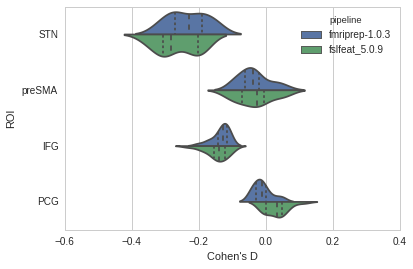

In [27]:
reslong = pd.melt(results,id_vars=['pipeline','samplesize'],
                  value_vars=labels.values(),var_name="ROI",value_name="Cohen's D")
sns.set_style("whitegrid")
sns.violinplot(x="Cohen's D",y='ROI',hue='pipeline',data=reslong[reslong.samplesize==90],
               split=True,inner='quartile')
plt.xlim([-0.6,0.4])

(-0.6, 0.4)

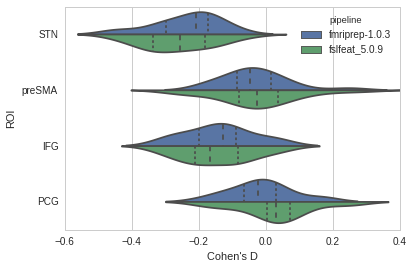

In [28]:
reslong = pd.melt(results,id_vars=['pipeline','samplesize'],
                  value_vars=labels.values(),var_name="ROI",value_name="Cohen's D")
sns.set_style("whitegrid")
sns.violinplot(x="Cohen's D",y='ROI',hue='pipeline',data=reslong[reslong.samplesize==30],
               split=True,inner='quartile')
plt.xlim([-0.6,0.4])

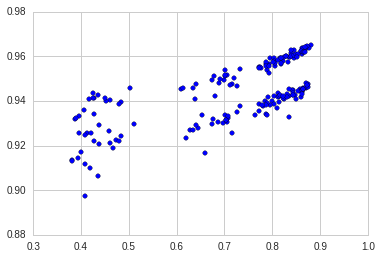

In [29]:
plt.scatter(results['correlation'],results['fdice'])

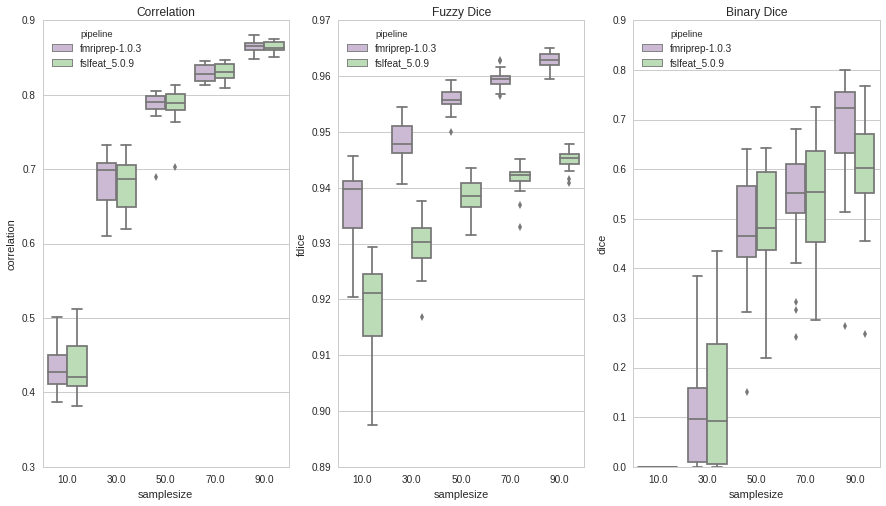

In [30]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(15,8), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1,3,1)
sns.boxplot(x="samplesize", y="correlation", hue="pipeline", data=results, palette="PRGn")
plt.title("Correlation")
plt.subplot(1,3,2)
sns.boxplot(x="samplesize", y="fdice", hue="pipeline", data=results, palette="PRGn")
plt.title("Fuzzy Dice")
plt.subplot(1,3,3)
sns.boxplot(x="samplesize", y="dice", hue="pipeline", data=results, palette="PRGn")
plt.title("Binary Dice")

In [31]:
fig = plt.figure(figsize=(15,8), dpi= 100, facecolor='w', edgecolor='k')

for idx,samplesize in enumerate(np.arange(10,31,20).tolist()):
    for idy,pipeline in enumerate(pipelines):
        if idy==0:
            lsty = '-'
        else:
            lsty = ':'
        sns.distplot(allT[pipeline][samplesize],color=cols[idx],hist=False,
                     kde_kws={"linestyle": lsty},label="%i subjects - %s"%(samplesize,pipeline))

plt.title("Distribution of T-values (whole brain)")
plt.legend()

KeyError: 10